In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torch import optim
from torchvision.datasets import SVHN, MNIST
from tqdm import tqdm

from src.data_utils import (
    TransformDataset,
    SrcDataset,
    DstDataset,
    get_train_weak_transform,
    get_train_strong_transform,
    get_test_transform,
)
from src.models import get_model
from src.reproducibility import set_seed
from src.loss import consistency_loss

In [2]:
# 入力画像サイズ
INPUT_SIZE = 32

# learning rate
# VIT_LR = 5e-5
# CNN_LR = 0.01
VIT_LR = 0.001
CNN_LR = 0.01


# Co training時の閾値
TH_CNN = 0.9
TH_VIT = 0.6

# 検証のステップ数
TEST_INTERVAL = 500

# 総ステップ数
ADAPT_ITERS = 5000

# Normalize時のmean, std
NORMALIZE_MEAN = 0.5
NORMALIZE_STD = 0.5

In [3]:
def get_source_dl(batch_size=32):
    weak_trans = get_train_weak_transform()
    test_trans = get_test_transform()
    train_mnist = MNIST(
        root='./mnist/',
        train=True,
        download=True,
    )
    test_mnist = MNIST(
        root='./mnist/',
        train=False,
        download=True,
        transform=test_trans
    )
    split_generator = torch.Generator().manual_seed(2024)
    train_mnist, valid_mnist = random_split(train_mnist, [0.8, 0.2], split_generator)
    train_mnist = SrcDataset(
        train_mnist,
        weak_trans,
    )
    valid_mnist = TransformDataset(
        valid_mnist,
        test_trans
    )
    dl_generator = torch.Generator().manual_seed(2024)
    src_train_dl = DataLoader(
        train_mnist,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        generator=dl_generator,
        drop_last=True,
    )
    src_valid_dl = DataLoader(
        valid_mnist,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
    )
    src_test_dl = DataLoader(
        test_mnist,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
    )
    return src_train_dl, src_valid_dl, src_test_dl


def get_target_dl(batch_size=32):
    weak_trans, strong_trans = get_train_weak_transform(), get_train_strong_transform(v=8)
    test_trans = get_test_transform()
    train_svhm = SVHN(
        root='./svhm/',
        split='train',
        download=True,
    )
    test_svhm = SVHN(
        root='./svhm/',
        split='test',
        download=True,
        transform=test_trans,
    )
    split_generator = torch.Generator().manual_seed(2024)
    train_svhm, valid_svhm = random_split(train_svhm, [0.8, 0.2], split_generator)
    train_svhm = DstDataset(
        train_svhm,
        weak_trans,
        strong_trans,
    )
    valid_svhm = TransformDataset(
        valid_svhm,
        test_trans,
    )
    dl_generator = torch.Generator().manual_seed(2024)
    dst_train_dl = DataLoader(
        train_svhm,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        generator=dl_generator,
        drop_last=True
    )
    dst_valid_dl = DataLoader(
        valid_svhm,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
    )
    dst_test_dl = DataLoader(
        test_svhm,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
    )
    return dst_train_dl, dst_valid_dl, dst_test_dl

In [4]:
src_train_dl, src_valid_dl, src_test_dl = get_source_dl()
dst_train_dl, dst_valid_dl, dst_test_dl = get_target_dl()

Using downloaded and verified file: ./svhm/train_32x32.mat
Using downloaded and verified file: ./svhm/test_32x32.mat


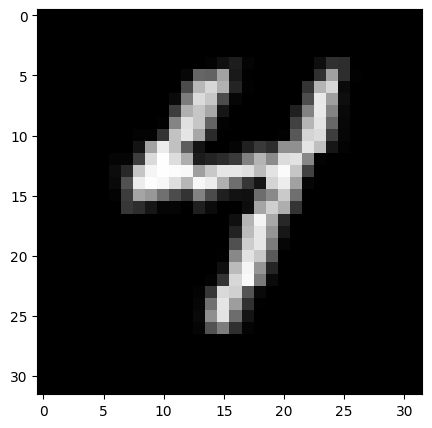

In [5]:
set_seed()
src_X_weak, src_y = next(iter(src_train_dl))
fig, ax = plt.subplots(figsize=(5, 5))
mean_tensor = torch.tensor(NORMALIZE_MEAN).unsqueeze(0).unsqueeze(0)
std_tensor = torch.tensor(NORMALIZE_STD).unsqueeze(0).unsqueeze(0)
idx = 0
ax.imshow(
    src_X_weak.permute(0, 2, 3, 1)[idx] * std_tensor +  mean_tensor
)
plt.show()

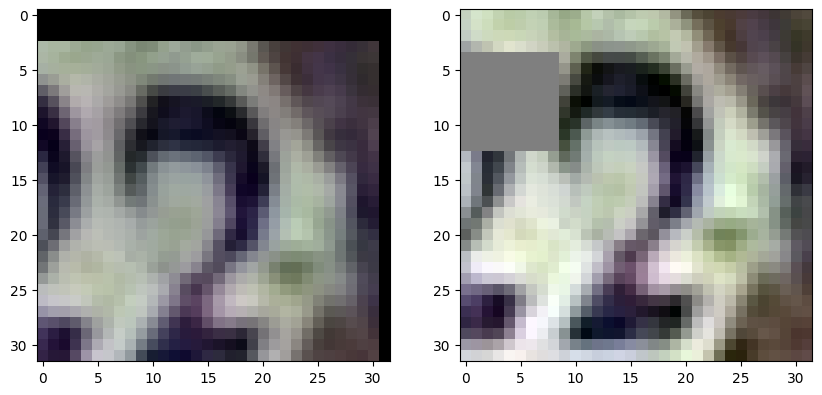

In [5]:
set_seed()
dst_X_weak, dst_X_strong = next(iter(dst_train_dl))
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
mean_tensor = torch.tensor(NORMALIZE_MEAN).unsqueeze(0).unsqueeze(0)
std_tensor = torch.tensor(NORMALIZE_STD).unsqueeze(0).unsqueeze(0)
idx = 30
axes[0].imshow(
    dst_X_weak.permute(0, 2, 3, 1)[idx] * std_tensor +  mean_tensor
)
axes[1].imshow(
    dst_X_strong.permute(0, 2, 3, 1)[idx] * std_tensor +  mean_tensor
)
plt.show()

In [5]:
def get_cnn_and_vit_model():
    G1, F1 = get_model(model_type='vit', num_feature_extractor_out=512)
    G2, F2 = get_model(model_type='cnn', num_feature_extractor_out=512)
    return (G1, F1, G2, F2)


def inv_lr_scheduler(param_lr, optimizer, iter_num, gamma=0.0001,
                     power=0.75, init_lr=0.001):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (1 + gamma * iter_num) ** (- power)
    i = 0
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr * param_lr[i]
        i += 1
    return optimizer


def train(
    G1,
    F1,
    G2,
    F2,
    optimizer_g1,
    optimizer_f1,
    optimizer_g2,
    optimizer_f2,
    src_train_dl,
    src_valid_dl,
    dst_train_dl,
    dst_valid_dl,
    adapt_iter,
    device='cuda' if torch.cuda.is_available() else 'cpu'
):
    ce_criterion = nn.CrossEntropyLoss()
    def zero_grad_all():
        optimizer_g1.zero_grad()
        optimizer_f1.zero_grad()
        optimizer_g2.zero_grad()
        optimizer_f2.zero_grad()

    len_src_dl = len(src_train_dl)
    len_dst_dl = len(dst_train_dl)

    param_lr_g1 = []
    for param_group in optimizer_g1.param_groups:
        param_lr_g1.append(param_group["lr"])
    param_lr_g2 = []
    for param_group in optimizer_g2.param_groups:
        param_lr_g2.append(param_group["lr"])
    param_lr_f1 = []
    for param_group in optimizer_f1.param_groups:
        param_lr_f1.append(param_group["lr"])
    param_lr_f2 = []
    for param_group in optimizer_f2.param_groups:
        param_lr_f2.append(param_group["lr"])
    for step in range(adapt_iter):
        optimizer_g1 = inv_lr_scheduler(
            param_lr_g1, optimizer_g1, step, init_lr=VIT_LR
        )
        optimizer_g2 = inv_lr_scheduler(
            param_lr_g2, optimizer_g2, step, init_lr=CNN_LR
        )
        optimizer_f1 = inv_lr_scheduler(param_lr_f1, optimizer_f1, step, init_lr=CNN_LR)
        optimizer_f2 = inv_lr_scheduler(param_lr_f2, optimizer_f2, step, init_lr=CNN_LR)

        G1.train()
        F1.train()
        G2.train()
        F2.train()
        if step % len_src_dl == 0:
            iter_src = iter(src_train_dl)
        if step % len_dst_dl == 0:
            iter_dst = iter(dst_train_dl)
        # データ準備
        src_X_weak, src_y = next(iter_src)
        dst_X_weak, dst_X_strong = next(iter_dst)
        src_X_weak = src_X_weak.to(device)
        src_y = src_y.to(device)
        dst_X_weak = dst_X_weak.to(device)
        dst_X_strong = dst_X_strong.to(device)

        labeled_targetw_tuple = [src_X_weak]
        labeled_gt = [src_y]
        nl = src_X_weak.size(0)

        labeled_targetw_input = torch.cat(
            labeled_targetw_tuple + [dst_X_weak],
            0
        )
        labeled_targetstr_input = torch.cat(
            labeled_targetw_tuple + [dst_X_strong],
            0
        )
        unlabeled_target_input = torch.cat(
            (dst_X_weak, dst_X_strong),
            0
        )
        labeled_input = torch.cat(labeled_targetw_tuple, 0)
        labeled_gt = torch.cat(labeled_gt, 0)

        zero_grad_all()
        # == 1. 教師あり学習実施 ==
        # 1.1 ViT
        vit_logits = F1(G1(labeled_input))
        vit_loss = ce_criterion(vit_logits, labeled_gt)

        vit_loss.backward()
        optimizer_g1.step()
        optimizer_f1.step()
        zero_grad_all()
        # 1.2 CNN
        cnn_logits = F2(G2(labeled_targetw_input))
        cnn_loss = ce_criterion(cnn_logits[:nl], labeled_gt)

        cnn_loss.backward()
        optimizer_g2.step()
        optimizer_f2.step()
        zero_grad_all()

        # 2. MCD
        # 2.1 Finding
        output_f1 = F1(G1(labeled_input))
        output_f2 = F2(G2(labeled_targetw_input))
        loss_f1 = ce_criterion(output_f1, labeled_gt)
        loss_f2 = ce_criterion(output_f2[:nl], labeled_gt)

        loss_s = loss_f1 + loss_f2

        vit_features_t = G1(unlabeled_target_input)
        output_t1 = F1(vit_features_t)
        output_t2 = F2(vit_features_t)
        loss_dis = torch.mean(
            torch.abs(
                F.softmax(output_t1, dim=1) - F.softmax(output_t2, dim=1)
            )
        )
        loss = loss_s - loss_dis
        loss.backward()
        optimizer_f1.step()
        optimizer_f2.step()
        zero_grad_all()

        # 2. Conquering
        for _ in range(4):
            feat_t = G2(unlabeled_target_input)
            output_t1 = F1(feat_t)
            output_t2 = F2(feat_t)
            loss_dis = torch.mean(
                torch.abs(
                    F.softmax(output_t1, dim=1) - F.softmax(output_t2, dim=1)
                )
            )
            loss_dis.backward()
            optimizer_g2.step()
            zero_grad_all()

        # 3. co training
        # 3.1 ViT -> CNN
        vit_logits = F1(G1(dst_X_weak))
        logits_u_s = F2(G2(labeled_targetstr_input))
        loss_vit_to_cnn = consistency_loss(
            logits_u_s[nl:], vit_logits, threshold=TH_VIT
        )
        loss_vit_to_cnn.backward()
        optimizer_g2.step()
        optimizer_f2.step()
        zero_grad_all()

        # # 3.2 CNN -> ViT
        logits_u_s = F1(G1(dst_X_strong))
        cnn_logits = F2(G2(labeled_targetw_input))
        loss_cnn_to_vit = consistency_loss(
            logits_u_s, cnn_logits[nl:], threshold=TH_CNN
        )
        loss_cnn_to_vit.backward()
        optimizer_g1.step()
        optimizer_f1.step()
        zero_grad_all()

        if step % 20 == 0 or step == adapt_iter -1:
            print(
                (
                    f'{step} / {adapt_iter} '
                    f'CNN loss={cnn_loss.item():.6f} ViT Loss={vit_loss.item():.6f} '
                    f'loss_vit_to_cnn={loss_vit_to_cnn.item():.6f} loss_cnn_to_vit={loss_cnn_to_vit.item():.6f}'
                )
            )

        if step % TEST_INTERVAL == 0 and step != 0:
            vit_src_acc, vit_src_loss = evaluate(
                G1,
                F1,
                ce_criterion,
                src_valid_dl,
                device,
            )
            cnn_src_acc, cnn_src_loss = evaluate(
                G2,
                F2,
                ce_criterion,
                src_valid_dl,
                device,
            )
            print('=== src ===')
            print(
                (
                    f'{step} / {adapt_iter} '
                    f'ViT acc={vit_src_acc:.6f} ViT Loss={vit_src_loss:.6f} '
                    f'CNN acc={cnn_src_acc:.6f} CNN Loss={cnn_src_loss:.6f}'
                )
            )
            vit_dst_acc, vit_dst_loss = evaluate(
                G1,
                F1,
                ce_criterion,
                dst_valid_dl,
                device,
            )
            cnn_dst_acc, cnn_dst_loss = evaluate(
                G2,
                F2,
                ce_criterion,
                dst_valid_dl,
                device,
            )
            print('=== dst ===')
            print(
                (
                    f'{step} / {adapt_iter} '
                    f'ViT acc={vit_dst_acc:.6f} ViT Loss={vit_dst_loss:.6f} '
                    f'CNN acc={cnn_dst_acc:.6f} CNN Loss={cnn_dst_loss:.6f}'
                )
            )


@torch.no_grad()
def evaluate(G, F, loss_fn, valid_dl, device):
    G.eval()
    F.eval()
    total_correct = 0
    total_data = 0
    total_loss = 0
    for X, y in tqdm(valid_dl, total=len(valid_dl)):
        X = X.to(device)
        y = y.to(device)
        pred = F(G(X))
        loss = loss_fn(pred, y)

        num_data = len(X)
        total_data += num_data
        total_correct += (torch.argmax(pred, dim=1) == y).sum().item()
        total_loss += loss.item() * total_data
    accuracy = total_correct / total_data
    avg_loss = total_loss / total_data
    return accuracy, avg_loss

In [6]:
set_seed(0)
(G1, F1, G2, F2) = get_cnn_and_vit_model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
G1.to(device)
F1.to(device)
G2.to(device)
F2.to(device)
optimizer_G1 = optim.AdamW(G1.parameters(), lr=0.1, weight_decay=0.0005)
optimizer_F1 = optim.AdamW(F1.parameters(), lr=1.0, weight_decay=0.0005)
optimizer_G2 = optim.AdamW(G2.parameters(), lr=0.1, weight_decay=0.0005)
optimizer_F2 = optim.AdamW(F2.parameters(), lr=1.0, weight_decay=0.0005)

src_train_dl, src_valid_dl, src_test_dl = get_source_dl()
dst_train_dl, dst_valid_dl, dst_test_dl = get_target_dl()
train(
    G1,
    F1,
    G2,
    F2,
    optimizer_G1,
    optimizer_F1,
    optimizer_G2,
    optimizer_G2,
    src_train_dl,
    src_valid_dl,
    dst_train_dl,
    dst_valid_dl,
    adapt_iter=ADAPT_ITERS,
)

Using downloaded and verified file: ./svhm/train_32x32.mat
Using downloaded and verified file: ./svhm/test_32x32.mat
0 / 5000 CNN loss=2.532627 ViT Loss=2.393779 loss_vit_to_cnn=0.487990 loss_cnn_to_vit=0.000000
20 / 5000 CNN loss=0.820890 ViT Loss=2.985768 loss_vit_to_cnn=0.107067 loss_cnn_to_vit=0.000000
40 / 5000 CNN loss=0.470867 ViT Loss=3.339298 loss_vit_to_cnn=0.091884 loss_cnn_to_vit=0.042747
60 / 5000 CNN loss=0.466893 ViT Loss=2.344454 loss_vit_to_cnn=0.083983 loss_cnn_to_vit=0.010348
80 / 5000 CNN loss=0.294526 ViT Loss=2.559297 loss_vit_to_cnn=0.226372 loss_cnn_to_vit=0.035942
100 / 5000 CNN loss=0.135727 ViT Loss=2.647902 loss_vit_to_cnn=0.162419 loss_cnn_to_vit=0.006132
120 / 5000 CNN loss=0.333949 ViT Loss=2.028172 loss_vit_to_cnn=0.244169 loss_cnn_to_vit=0.438521
140 / 5000 CNN loss=0.269805 ViT Loss=1.965617 loss_vit_to_cnn=0.050926 loss_cnn_to_vit=0.003454
160 / 5000 CNN loss=0.103774 ViT Loss=2.466851 loss_vit_to_cnn=0.022243 loss_cnn_to_vit=0.000245
180 / 5000 CNN l

100%|██████████| 375/375 [00:00<00:00, 415.90it/s]


=== src ===
500 / 5000 ViT acc=0.463500 ViT Loss=261.675970 CNN acc=0.932750 CNN Loss=47.160396


100%|██████████| 458/458 [00:01<00:00, 425.30it/s]


=== dst ===
500 / 5000 ViT acc=0.176711 ViT Loss=5180.042646 CNN acc=0.191728 CNN Loss=1150.256027
520 / 5000 CNN loss=0.064220 ViT Loss=1.179096 loss_vit_to_cnn=0.436534 loss_cnn_to_vit=0.000000
540 / 5000 CNN loss=0.305550 ViT Loss=1.870894 loss_vit_to_cnn=0.595047 loss_cnn_to_vit=0.000002
560 / 5000 CNN loss=0.400372 ViT Loss=1.699134 loss_vit_to_cnn=0.017815 loss_cnn_to_vit=0.000000
580 / 5000 CNN loss=0.250086 ViT Loss=1.291573 loss_vit_to_cnn=0.011052 loss_cnn_to_vit=0.000000
600 / 5000 CNN loss=0.047109 ViT Loss=1.236238 loss_vit_to_cnn=0.009348 loss_cnn_to_vit=0.000000
620 / 5000 CNN loss=0.046350 ViT Loss=1.146424 loss_vit_to_cnn=0.026204 loss_cnn_to_vit=0.000000
640 / 5000 CNN loss=0.259222 ViT Loss=2.054602 loss_vit_to_cnn=0.036482 loss_cnn_to_vit=0.000557
660 / 5000 CNN loss=0.200142 ViT Loss=1.499594 loss_vit_to_cnn=0.166821 loss_cnn_to_vit=0.000000
680 / 5000 CNN loss=0.105167 ViT Loss=1.997890 loss_vit_to_cnn=0.170686 loss_cnn_to_vit=0.000000
700 / 5000 CNN loss=0.252112

100%|██████████| 375/375 [00:00<00:00, 428.41it/s]


=== src ===
1000 / 5000 ViT acc=0.643750 ViT Loss=184.384073 CNN acc=0.978167 CNN Loss=17.097444


100%|██████████| 458/458 [00:01<00:00, 434.32it/s]


=== dst ===
1000 / 5000 ViT acc=0.179715 ViT Loss=4749.801391 CNN acc=0.190704 CNN Loss=1244.955593
1020 / 5000 CNN loss=0.044904 ViT Loss=1.162176 loss_vit_to_cnn=0.477617 loss_cnn_to_vit=0.000000
1040 / 5000 CNN loss=0.103967 ViT Loss=1.275830 loss_vit_to_cnn=0.347483 loss_cnn_to_vit=0.000000
1060 / 5000 CNN loss=0.094406 ViT Loss=1.081126 loss_vit_to_cnn=0.264708 loss_cnn_to_vit=0.000000
1080 / 5000 CNN loss=0.093790 ViT Loss=1.209137 loss_vit_to_cnn=0.217188 loss_cnn_to_vit=0.000000
1100 / 5000 CNN loss=0.093706 ViT Loss=1.082881 loss_vit_to_cnn=0.080098 loss_cnn_to_vit=0.000000
1120 / 5000 CNN loss=0.307621 ViT Loss=1.112952 loss_vit_to_cnn=0.325941 loss_cnn_to_vit=0.000000
1140 / 5000 CNN loss=0.050232 ViT Loss=0.520576 loss_vit_to_cnn=0.454011 loss_cnn_to_vit=0.000010
1160 / 5000 CNN loss=0.069801 ViT Loss=1.224638 loss_vit_to_cnn=0.184376 loss_cnn_to_vit=0.000000
1180 / 5000 CNN loss=0.074776 ViT Loss=1.048885 loss_vit_to_cnn=0.021695 loss_cnn_to_vit=0.000000
1200 / 5000 CNN lo

100%|██████████| 375/375 [00:00<00:00, 427.64it/s]


=== src ===
1500 / 5000 ViT acc=0.794000 ViT Loss=116.353754 CNN acc=0.961250 CNN Loss=28.066750


100%|██████████| 458/458 [00:01<00:00, 420.04it/s]


=== dst ===
1500 / 5000 ViT acc=0.185380 ViT Loss=10091.167870 CNN acc=0.190362 CNN Loss=1294.833605
1520 / 5000 CNN loss=0.041242 ViT Loss=0.679364 loss_vit_to_cnn=0.264213 loss_cnn_to_vit=0.000000
1540 / 5000 CNN loss=0.129784 ViT Loss=1.163720 loss_vit_to_cnn=0.157011 loss_cnn_to_vit=0.000001
1560 / 5000 CNN loss=0.029556 ViT Loss=0.377606 loss_vit_to_cnn=0.088804 loss_cnn_to_vit=0.000000
1580 / 5000 CNN loss=0.013715 ViT Loss=0.591912 loss_vit_to_cnn=0.423613 loss_cnn_to_vit=0.000000
1600 / 5000 CNN loss=0.013745 ViT Loss=0.475514 loss_vit_to_cnn=0.086095 loss_cnn_to_vit=0.000000
1620 / 5000 CNN loss=0.275786 ViT Loss=0.688141 loss_vit_to_cnn=0.016480 loss_cnn_to_vit=0.000000
1640 / 5000 CNN loss=0.331970 ViT Loss=0.380232 loss_vit_to_cnn=0.016524 loss_cnn_to_vit=0.000000
1660 / 5000 CNN loss=0.262166 ViT Loss=1.416629 loss_vit_to_cnn=0.333444 loss_cnn_to_vit=0.000000
1680 / 5000 CNN loss=0.024230 ViT Loss=0.537854 loss_vit_to_cnn=0.108546 loss_cnn_to_vit=0.000000
1700 / 5000 CNN l

100%|██████████| 375/375 [00:00<00:00, 430.96it/s]


=== src ===
2000 / 5000 ViT acc=0.872167 ViT Loss=75.853210 CNN acc=0.919750 CNN Loss=47.588933


100%|██████████| 458/458 [00:01<00:00, 413.87it/s]


=== dst ===
2000 / 5000 ViT acc=0.190226 ViT Loss=11229.139636 CNN acc=0.190089 CNN Loss=1396.421826
2020 / 5000 CNN loss=0.085541 ViT Loss=0.715389 loss_vit_to_cnn=0.017984 loss_cnn_to_vit=0.000000
2040 / 5000 CNN loss=0.131708 ViT Loss=0.699002 loss_vit_to_cnn=0.019512 loss_cnn_to_vit=0.000000
2060 / 5000 CNN loss=0.012331 ViT Loss=0.352804 loss_vit_to_cnn=0.225035 loss_cnn_to_vit=0.000000
2080 / 5000 CNN loss=0.100966 ViT Loss=0.856393 loss_vit_to_cnn=0.141976 loss_cnn_to_vit=0.000000
2100 / 5000 CNN loss=0.082610 ViT Loss=0.904512 loss_vit_to_cnn=0.184010 loss_cnn_to_vit=0.000000
2120 / 5000 CNN loss=0.024997 ViT Loss=0.434622 loss_vit_to_cnn=0.354717 loss_cnn_to_vit=0.000000
2140 / 5000 CNN loss=0.056731 ViT Loss=0.472545 loss_vit_to_cnn=0.094888 loss_cnn_to_vit=0.000000
2160 / 5000 CNN loss=0.261833 ViT Loss=0.938232 loss_vit_to_cnn=0.019443 loss_cnn_to_vit=0.000000
2180 / 5000 CNN loss=0.014308 ViT Loss=0.351642 loss_vit_to_cnn=0.008409 loss_cnn_to_vit=0.000000
2200 / 5000 CNN l

100%|██████████| 375/375 [00:00<00:00, 420.47it/s]


=== src ===
2500 / 5000 ViT acc=0.917083 ViT Loss=49.371568 CNN acc=0.925083 CNN Loss=45.335983


100%|██████████| 458/458 [00:01<00:00, 394.83it/s]


=== dst ===
2500 / 5000 ViT acc=0.189270 ViT Loss=12832.653288 CNN acc=0.190362 CNN Loss=1370.620242
2520 / 5000 CNN loss=0.011044 ViT Loss=0.335341 loss_vit_to_cnn=0.013263 loss_cnn_to_vit=0.000000
2540 / 5000 CNN loss=0.040564 ViT Loss=0.513601 loss_vit_to_cnn=0.017256 loss_cnn_to_vit=0.000000
2560 / 5000 CNN loss=0.073984 ViT Loss=0.423842 loss_vit_to_cnn=0.119898 loss_cnn_to_vit=0.000000
2580 / 5000 CNN loss=0.012584 ViT Loss=0.329787 loss_vit_to_cnn=0.256585 loss_cnn_to_vit=0.000006
2600 / 5000 CNN loss=0.009723 ViT Loss=0.240024 loss_vit_to_cnn=0.026790 loss_cnn_to_vit=0.002227
2620 / 5000 CNN loss=0.026701 ViT Loss=0.340931 loss_vit_to_cnn=0.008126 loss_cnn_to_vit=0.000411
2640 / 5000 CNN loss=0.178550 ViT Loss=0.891774 loss_vit_to_cnn=0.083171 loss_cnn_to_vit=0.000025
2660 / 5000 CNN loss=0.101015 ViT Loss=0.360372 loss_vit_to_cnn=0.220419 loss_cnn_to_vit=0.000553
2680 / 5000 CNN loss=0.048970 ViT Loss=0.487520 loss_vit_to_cnn=0.011263 loss_cnn_to_vit=0.000014
2700 / 5000 CNN l

100%|██████████| 375/375 [00:00<00:00, 426.04it/s]


=== src ===
3000 / 5000 ViT acc=0.905833 ViT Loss=54.765415 CNN acc=0.967500 CNN Loss=26.616793


100%|██████████| 458/458 [00:01<00:00, 417.58it/s]


=== dst ===
3000 / 5000 ViT acc=0.189816 ViT Loss=3279.771001 CNN acc=0.189407 CNN Loss=1413.527001
3020 / 5000 CNN loss=0.105683 ViT Loss=0.425086 loss_vit_to_cnn=0.018381 loss_cnn_to_vit=0.000030
3040 / 5000 CNN loss=0.015110 ViT Loss=0.462968 loss_vit_to_cnn=0.007575 loss_cnn_to_vit=0.000017
3060 / 5000 CNN loss=0.014134 ViT Loss=0.146073 loss_vit_to_cnn=0.162398 loss_cnn_to_vit=0.000178
3080 / 5000 CNN loss=0.040972 ViT Loss=0.279267 loss_vit_to_cnn=0.065765 loss_cnn_to_vit=0.000029
3100 / 5000 CNN loss=0.019927 ViT Loss=0.490794 loss_vit_to_cnn=0.010052 loss_cnn_to_vit=0.000040
3120 / 5000 CNN loss=0.366753 ViT Loss=0.745520 loss_vit_to_cnn=0.017879 loss_cnn_to_vit=0.000039
3140 / 5000 CNN loss=0.214882 ViT Loss=0.233174 loss_vit_to_cnn=0.018404 loss_cnn_to_vit=0.000460
3160 / 5000 CNN loss=0.054936 ViT Loss=0.359655 loss_vit_to_cnn=0.014170 loss_cnn_to_vit=0.000264
3180 / 5000 CNN loss=0.157667 ViT Loss=0.433081 loss_vit_to_cnn=0.199493 loss_cnn_to_vit=0.000002
3200 / 5000 CNN lo

100%|██████████| 375/375 [00:00<00:00, 430.39it/s]


=== src ===
3500 / 5000 ViT acc=0.909667 ViT Loss=54.655810 CNN acc=0.812750 CNN Loss=116.236301


100%|██████████| 458/458 [00:01<00:00, 430.44it/s]


=== dst ===
3500 / 5000 ViT acc=0.189134 ViT Loss=3400.383212 CNN acc=0.188793 CNN Loss=1442.401115
3520 / 5000 CNN loss=0.006705 ViT Loss=0.177069 loss_vit_to_cnn=0.007179 loss_cnn_to_vit=0.000000
3540 / 5000 CNN loss=0.021411 ViT Loss=0.169638 loss_vit_to_cnn=0.005302 loss_cnn_to_vit=0.000203
3560 / 5000 CNN loss=0.055266 ViT Loss=0.681354 loss_vit_to_cnn=0.171835 loss_cnn_to_vit=0.000004
3580 / 5000 CNN loss=0.016610 ViT Loss=0.580733 loss_vit_to_cnn=0.007427 loss_cnn_to_vit=0.000109
3600 / 5000 CNN loss=0.006126 ViT Loss=0.116083 loss_vit_to_cnn=0.009484 loss_cnn_to_vit=0.000102
3620 / 5000 CNN loss=0.044082 ViT Loss=0.271475 loss_vit_to_cnn=0.021517 loss_cnn_to_vit=0.000033
3640 / 5000 CNN loss=0.049737 ViT Loss=0.771004 loss_vit_to_cnn=0.026339 loss_cnn_to_vit=0.000042
3660 / 5000 CNN loss=0.008596 ViT Loss=0.177856 loss_vit_to_cnn=0.009524 loss_cnn_to_vit=0.000283
3680 / 5000 CNN loss=0.016242 ViT Loss=0.288469 loss_vit_to_cnn=0.007677 loss_cnn_to_vit=0.000006
3700 / 5000 CNN lo

100%|██████████| 375/375 [00:00<00:00, 444.72it/s]


=== src ===
4000 / 5000 ViT acc=0.943750 ViT Loss=35.907768 CNN acc=0.970917 CNN Loss=24.872609


100%|██████████| 458/458 [00:01<00:00, 393.06it/s]


=== dst ===
4000 / 5000 ViT acc=0.189270 ViT Loss=3148.100240 CNN acc=0.189270 CNN Loss=1463.154707
4020 / 5000 CNN loss=0.030113 ViT Loss=0.475778 loss_vit_to_cnn=0.017139 loss_cnn_to_vit=0.000068
4040 / 5000 CNN loss=0.011202 ViT Loss=0.327970 loss_vit_to_cnn=0.006054 loss_cnn_to_vit=0.000428
4060 / 5000 CNN loss=0.010484 ViT Loss=0.415751 loss_vit_to_cnn=0.006624 loss_cnn_to_vit=0.001600
4080 / 5000 CNN loss=0.074878 ViT Loss=0.268991 loss_vit_to_cnn=0.163495 loss_cnn_to_vit=0.000004
4100 / 5000 CNN loss=0.080051 ViT Loss=0.110343 loss_vit_to_cnn=0.160314 loss_cnn_to_vit=0.000232
4120 / 5000 CNN loss=0.010317 ViT Loss=0.420078 loss_vit_to_cnn=0.008883 loss_cnn_to_vit=0.000011
4140 / 5000 CNN loss=0.026023 ViT Loss=0.489090 loss_vit_to_cnn=0.009817 loss_cnn_to_vit=0.000094
4160 / 5000 CNN loss=0.013663 ViT Loss=0.241765 loss_vit_to_cnn=0.077454 loss_cnn_to_vit=0.000020
4180 / 5000 CNN loss=0.047043 ViT Loss=0.383962 loss_vit_to_cnn=0.023368 loss_cnn_to_vit=0.000119
4200 / 5000 CNN lo

100%|██████████| 375/375 [00:00<00:00, 419.13it/s]


=== src ===
4500 / 5000 ViT acc=0.938417 ViT Loss=40.045700 CNN acc=0.846000 CNN Loss=98.353066


100%|██████████| 458/458 [00:01<00:00, 435.94it/s]


=== dst ===
4500 / 5000 ViT acc=0.185858 ViT Loss=2946.008230 CNN acc=0.186950 CNN Loss=1458.362529
4520 / 5000 CNN loss=0.096071 ViT Loss=0.570485 loss_vit_to_cnn=0.011916 loss_cnn_to_vit=0.001406
4540 / 5000 CNN loss=0.022311 ViT Loss=0.276208 loss_vit_to_cnn=0.019623 loss_cnn_to_vit=0.000488
4560 / 5000 CNN loss=0.131973 ViT Loss=0.552646 loss_vit_to_cnn=0.011326 loss_cnn_to_vit=0.000076
4580 / 5000 CNN loss=0.012039 ViT Loss=0.295018 loss_vit_to_cnn=0.023183 loss_cnn_to_vit=0.001130
4600 / 5000 CNN loss=0.034351 ViT Loss=0.355544 loss_vit_to_cnn=0.058215 loss_cnn_to_vit=0.000011
4620 / 5000 CNN loss=0.006795 ViT Loss=0.096680 loss_vit_to_cnn=0.005989 loss_cnn_to_vit=0.000644
4640 / 5000 CNN loss=0.037330 ViT Loss=0.103836 loss_vit_to_cnn=0.082684 loss_cnn_to_vit=0.000003
4660 / 5000 CNN loss=0.331952 ViT Loss=0.483229 loss_vit_to_cnn=0.006088 loss_cnn_to_vit=0.000099
4680 / 5000 CNN loss=0.094009 ViT Loss=0.202508 loss_vit_to_cnn=0.004266 loss_cnn_to_vit=0.000151
4700 / 5000 CNN lo

In [7]:
loss_fn = nn.CrossEntropyLoss()
src_vit_test_acc, _ = evaluate(
    G1,
    F1,
    loss_fn,
    src_test_dl,
    device,
)
src_cnn_test_acc, _ = evaluate(
    G2,
    F2,
    loss_fn,
    src_test_dl,
    device,
)
print(f'SRC Test vit acc={src_vit_test_acc:.6f}, cnn acc={src_cnn_test_acc:.6f}')


loss_fn = nn.CrossEntropyLoss()
dst_vit_test_acc, _ = evaluate(
    G1,
    F1,
    loss_fn,
    dst_test_dl,
    device,
)
dst_cnn_test_acc, _ = evaluate(
    G2,
    F2,
    loss_fn,
    dst_test_dl,
    device,
)
print(f'DST Test vit acc={dst_vit_test_acc:.6f}, cnn acc={dst_cnn_test_acc:.6f}')

100%|██████████| 313/313 [00:00<00:00, 395.44it/s]


SRC Test vit acc=0.933000, cnn acc=0.987300


100%|██████████| 814/814 [00:01<00:00, 426.20it/s]

DST Test vit acc=0.195682, cnn acc=0.196681
